# GeoSpatial II

In [1]:
import pandas as pd

In [2]:
from pathlib import Path

# creating a relative path to the data folder 
pth = Path('../../data')

In [3]:
# read canvas csv file into a dataframe 
canvas = pd.read_csv(pth / 'canvas.csv')

In [4]:
# read graffito
graffiti = pd.read_csv(pth /'graffiti.csv')

In [5]:
graffiti.columns

Index(['id', 'canvas_id', 'created_at', 'uploaded_at', 'created_by', 'title',
       'num', 'date_recorded', 'width', 'height', 'type', 'technique',
       'marker_type', 'nip_type', 'other', 'num_colors', 'colors',
       'nature_graffiti', 'transcribable', 'message', 'transcription'],
      dtype='object')

We want to create a single table that combines certain columns of the canvas and graffiti DataFrames.

In [6]:
keep_canvas = ['id', 'coords']
keep_graffiti = ['canvas_id', 'type']

In [7]:
from ast import literal_eval
from numpy import nan
def extract(row, key):
    dct = literal_eval(row)
    value = dct[key]
    if value =='':
        value = nan
        return
    else:
        return float(value)

In [8]:
df = (canvas.loc[:,keep_canvas]
            .assign(lat= canvas.coords.apply(extract, key='latitude'))  #apply function and create a column with latitude
            .assign(long=canvas.coords.apply(extract, key='longitude')) #apply function and create a column with latitude
            .dropna(subset=['lat', 'long']) # remove any entries with no lat or long
            .merge(graffiti.loc[:,keep_graffiti], left_on='id', right_on='canvas_id', how='inner')
)

## GeoPandas

[GeoPandas](https://geopandas.org/en/stable/index.html) is a package based on Pandas that handles spatial information. We will use it here to read the polygons that make up the 2020 [Census Block Groups](https://en.wikipedia.org/wiki/Census_block_group) for Seattle.

In [9]:
import geopandas as gpd

In [10]:
# read king county blog group polygon data
fn = pth/ 'spatial' / '2020_Census_Block_Groups_-_Seattle.dbf'
bg = gpd.read_file(fn)

Make sure that our map is in lat/long world coordinates.

In [11]:
bg = bg.to_crs('EPSG:4326')

Display the map,

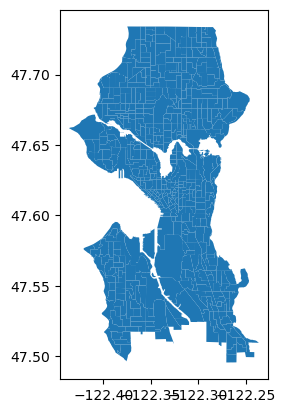

In [12]:
# plot it
bg.plot();

In [13]:
# check types
bg.dtypes

OBJECTID         int32
GEOID20         object
GROSS_ACRE     float64
ACRES_LAND     float64
ACRES_WATE     float64
TRBG           float64
NAMELSAD        object
BG               int32
TRACT            int32
TRACT_LABE      object
Shape__Are     float64
Shape__Len     float64
geometry      geometry
dtype: object

In [14]:
# convert geoid20 to string
bg['GEOID20'] = bg.GEOID20.astype('string')

We want to generate a simple map showing all canvas locations within a selected Group Block. We build this in steps,

### Selecting a Block Group

The Block Group we are interested has the following identifier,

In [15]:
# assign a string to the bg_id 
bg_id ='074032' #'084011' #'530330084011'

Next, we want to generate a function that will return a new GeoDataFrame given a Block Group id.

In [16]:
#create outline function
def select_block_group(bg, col_id, bg_id):
  '''
  This function returns a geodataframe for only the queried block group
  
  Parameters
  -----------
  bg: GeoPandasDataFrame containing blockgroup IDs and geometry information
  bg_id: a string value of the block group in question
  '''

  sel = bg[col_id].str[-6:] == bg_id #queries string
  my_bg = bg.loc[sel, :]
  return my_bg

In [17]:
#run the function
my_bg = select_block_group(bg, 'GEOID20', bg_id)
my_bg

,OBJECTID,GEOID20,GROSS_ACRE,ACRES_LAND,ACRES_WATE,TRBG,NAMELSAD,BG,TRACT,TRACT_LABE,Shape__Are,Shape__Len,geometry
284,372,530330074032,16.599759,16.601034,0.0,7403.2,Block Group 2,2,7403,74.03,723088.376953,3786.63861,"POLYGON ((-122.32092 47.62313, -122.32091 47.6..."


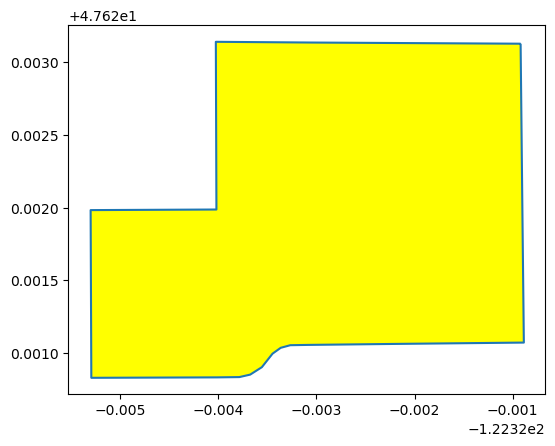

In [18]:
# test the plot
my_bg.boundary.plot(facecolor= 'yellow');

### Create Point Layers

Create a point layer for canvas locations inside and outside of our selected Group Block 

In [19]:
#create points
all_graf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.long,df.lat, crs = 'EPSG:4326'))
all_graf.head(5)

,id,coords,lat,long,canvas_id,type,geometry
0,3,"{'latitude': 47.658577, 'longitude': -122.3176...",47.658577,-122.317607,3,piece,POINT (-122.31761 47.65858)
1,3,"{'latitude': 47.658577, 'longitude': -122.3176...",47.658577,-122.317607,3,piece,POINT (-122.31761 47.65858)
2,3,"{'latitude': 47.658577, 'longitude': -122.3176...",47.658577,-122.317607,3,tag,POINT (-122.31761 47.65858)
3,3,"{'latitude': 47.658577, 'longitude': -122.3176...",47.658577,-122.317607,3,hollow,POINT (-122.31761 47.65858)
4,4,"{'latitude': 47.661615, 'longitude': -122.3204...",47.661615,-122.320492,4,tag,POINT (-122.32049 47.66162)


We want to be able to identify each canvas location with its Group Block Id. To do this, we use a [spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html).

In [20]:
all_graf = gpd.sjoin(all_graf, bg, how='inner', predicate='intersects')
all_graf.GEOID20

0       530330053052
1       530330053052
2       530330053052
3       530330053052
4       530330052013
            ...     
3456    530330053061
3457    530330053061
3458    530330053061
3459    530330053062
3460    530330053062
Name: GEOID20, Length: 3460, dtype: string

Select canvas locations inside and outside selected Group Block.

In [21]:
# create block group selection
sel = all_graf.GEOID20.str[-6:] == bg_id
bg_sel = all_graf.loc[sel, :] 

In [22]:
# create remaining selection
remains = all_graf.loc[all_graf.GEOID20.str[-6:] != bg_id, :]

### Plot all together

In [23]:
# find coordinate boundaries
xmin, ymin, xmax, ymax = my_bg.bounds.iloc[0].values.tolist()

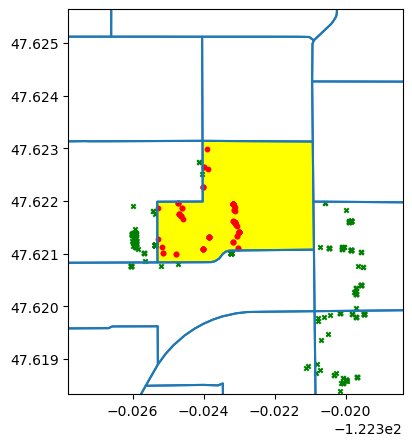

In [24]:
#plot mine vs others
base = bg.boundary.plot(figsize = (10,5))
ax = my_bg.plot(ax = base, color = 'yellow')
bg_sel.plot(ax = base, marker = 'o', color = 'red', markersize = 10)
remains.plot(ax = base, marker = 'x', color = 'green', markersize = 10)
ax.set_xlim(xmin-0.0025, xmax+0.0025)
ax.set_ylim(ymin-0.0025, ymax+0.0025);